In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import math as mt
import datetime as dt
import random as ran
from sklearn.metrics.pairwise import euclidean_distances as euc

# 한글출력
matplotlib.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

from src.dbc import TimeDivisionKMeans
from src.dbc.utils import data_preprocessing, dimension_reduction, calc_contribution

In [4]:
# 1. load_excel
data_path = "data/apt_1.xlsx"
xlsx = pd.read_excel(data_path, header=None,
                     skiprows=2, engine="openpyxl")

# 2. data preprocessing
df = data_preprocessing(xlsx)

# 3. dimension_reduction
df = dimension_reduction(df)

# 4. day clustering
df = df[:24]

In [8]:
# 개별 기여도 확인
# 해당 프로젝트의 목표 중, 단일계약 상에서 최대 사용량 가구의 전기를 아끼게 만들어 단일계약상에서의 공동설비사용요금을 줄이고,
# 이를 통해 형평성 있는 가격분배가 이루어지도록 하는 목적이 있다지만,
# 최대 사용량 가구의 가격 부담율이 매우 증가할 수 있다. -> 집단화를 통해 부담율의 오차를 줄여본다.
cols = df.columns
total_kwh = df.values.sum()

sum_df = (df.sum() * 1000).round() / 1000
cont_df = df.sum() / total_kwh

min_h = cols[sum_df.argmin()]
max_h = cols[sum_df.argmax()]
print("실제 (합산치 상에서의) 최소, 최대 사용량 가구")
print("- 최소: {} ({}kwh) / 최대: {} ({}kwh)\n".format(
    min_h,
    sum_df[min_h],
    max_h,
    sum_df[max_h]
))

_min_h = cols[cont_df.argmin()]
_max_h = cols[cont_df.argmax()]
print("기여도 최소, 최대 사용량 가구")
print("- 최소: {} ({}kwh) (기여도: {}%) / 최대: {} ({}kwh) (기여도: {}%)\n".format(
    _min_h,
    sum_df[min_h],
    cont_df[_min_h],
    _max_h,
    sum_df[max_h],
    cont_df[_max_h]
))
print("- 최소사용량 가구 기여도 , 최대사용량 가구 기여도 비교 {}배".format(round(cont_df[_max_h] / cont_df[_min_h])))

실제 (합산치 상에서의) 최소, 최대 사용량 가구
- 최소: 아파트1-104-1208 (0.219kwh) / 최대: 아파트1-103-703 (15.63kwh)

기여도 최소, 최대 사용량 가구
- 최소: 아파트1-104-1208 (0.219kwh) (기여도: 0.0002511692559655565%) / 최대: 아파트1-103-703 (15.63kwh) (기여도: 0.017925915391514377%)

- 최소사용량 가구 기여도 , 최대사용량 가구 기여도 비교 71배


문제 #1. 여전히 최소사용량 가구 집단과 최대사용량 가구 집단간의 기여도 차이가 많이 발생한다.
- 최소사용량 집단 기여도 , 최대사용량 집단 기여도 비교 71배

문제 #2. 단 1kWh의 차이로 다른 집단에 들어가게 됐을 때의 가격 증가폭이 커질 수 있다.
- 최소사용량 집단 기여도 , 최소사용량 + 1 집단 기여도 비교 11배

문제 #3. 히스토그램은 범위에 해당하는 x와 y가 있는 표현 방식이다.
해당 방식으로 진행해서 가격 분배를 하게 될 경우, 기여도가 많이 분배되어 있는 집단에 속한 가구(y)가 얼마 없다면
적은 가구들이 해당 기여도에 따른 공동설비사용요금을 지불하게 될 것 이다.


<AxesSubplot:>

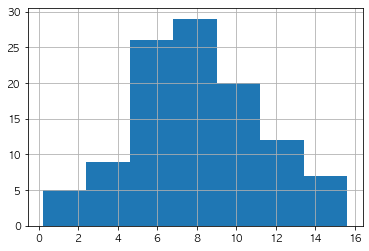

In [9]:
# 히스토그램 기여도 확인 (집단화 방식 #1)
K = round(mt.sqrt(len(df.columns) / 2))

sum_df = df.sum()
hist_y,hist_x = np.histogram(sum_df, bins=K)
cont_hist = hist_x / hist_x.sum()

_min_h = cont_hist.argmin()
_max_h = cont_hist.argmax()
print("문제 #1. 여전히 최소사용량 가구 집단과 최대사용량 가구 집단간의 기여도 차이가 많이 발생한다.")
print("- 최소사용량 집단 기여도 , 최대사용량 집단 기여도 비교 {}배\n".format(round(cont_hist[_max_h] / cont_hist[_min_h])))
print("문제 #2. 단 1kWh의 차이로 다른 집단에 들어가게 됐을 때의 가격 증가폭이 커질 수 있다.")
print("- 최소사용량 집단 기여도 , 최소사용량 + 1 집단 기여도 비교 {}배\n".format(round(cont_hist[1] / cont_hist[0])))
print("문제 #3. 히스토그램은 범위에 해당하는 x와 y가 있는 표현 방식이다.")
print("해당 방식으로 진행해서 가격 분배를 하게 될 경우, 기여도가 많이 분배되어 있는 집단에 속한 가구(y)가 얼마 없다면")
print("적은 가구들이 해당 기여도에 따른 공동설비사용요금을 지불하게 될 것 이다.")
sum_df.hist(bins=K)

In [21]:
# 일반 euclidean distance KMeans 방식
tdKMeans_24 = TimeDivisionKMeans(df, size=24)
hc_24, ci_24 = tdKMeans_24.run()

_hc = hc_24.copy()
_test = list()

for col in _hc:
    _hc_info = _hc[col].copy()
    contributions = [ci_24[division_round][1][int(_)] for division_round,_ in enumerate(_hc_info)]
    _test.append(contributions.copy())

contribution_df = pd.DataFrame(_test).T
contribution_df.columns = df.columns

contribution_df

# 실제(합산치 상에서의) 최소, 최대 사용량 가구
cols = df.columns

sum_df = (df.sum() * 1000).round() / 1000
min_h = cols[sum_df.argmin()]
max_h = cols[sum_df.argmax()]
print("실제 (합산치 상에서의) 최소, 최대 사용량 가구")
print("- 최소: {} ({}kwh) / 최대: {} ({}kwh)\n".format(
    min_h,
    sum_df[min_h],
    max_h,
    sum_df[max_h]
))

mean_cont_df = contribution_df.mean().round().astype("int")
_min_h = cols[mean_cont_df.argmin()]
_max_h = cols[mean_cont_df.argmax()]
print("기여도 최소, 최대 사용량 가구")
print("- 최소: {} ({}kwh) (기여도: {}%) / 최대: {} ({}kwh) (기여도: {}%)\n".format(
    _min_h,
    sum_df[min_h],
    mean_cont_df[_min_h],
    _max_h,
    sum_df[max_h],
    mean_cont_df[_max_h]
))
print("발견 #1. 클러스터링 방식의 기여도 분배는 다른 분배 방식들과 다르게 최대사용량 가구의 부담을 덜어줄 수 있었다.")
print("- 최소사용량 가구 기여도 , 최대사용량 가구 기여도 비교 {}배".format(round(mean_cont_df[_max_h] / mean_cont_df[_min_h])))

실제 (합산치 상에서의) 최소, 최대 사용량 가구
- 최소: 아파트1-104-1208 (0.219kwh) / 최대: 아파트1-103-703 (15.63kwh)

기여도 최소, 최대 사용량 가구
- 최소: 아파트1-104-1206 (0.219kwh) (기여도: 6%) / 최대: 아파트1-101-402 (15.63kwh) (기여도: 22%)

발견 #1. 클러스터링 방식의 기여도 분배는 다른 분배 방식들과 다르게 최대사용량 가구의 부담을 덜어줄 수 있었다.
- 최소사용량 가구 기여도 , 최대사용량 가구 기여도 비교 4배


In [22]:
print("문제 #1. KMeans Clustering은 아웃라이어에 민감한 알고리즘이다. 이는 군집의 멤버가 하나 밖에 없는 경우를 이야기하며,")
print("히스토그램 문제에서도 이야기 했던, 해당 아웃라이어 군집의 기여도가 높다면, 적은 가구 혹은 하나의 가구가 해당 기여도에 따른 가격을 지불해야 한다.\n")
print("- 추가 #. 최종적으로 산정되는 요금은 모든 가구의 총 사용량에 따라 달라짐으로, 아웃라이어를 제거해도 안된다.")
cnt_hc_24 = hc_24.T.groupby(hc_24.T[0]).count()

print("아웃라이어 발생 클러스터 : {}".format(int(cnt_hc_24[cnt_hc_24[0] <= 3].index[0])))
print("아웃라이어 클러스터 기여도 : {}%".format(ci_24[0][1][int(cnt_hc_24[cnt_hc_24[0] <= 3].index[0])]))

문제 #1. KMeans Clustering은 아웃라이어에 민감한 알고리즘이다. 이는 군집의 멤버가 하나 밖에 없는 경우를 이야기하며,
히스토그램 문제에서도 이야기 했던, 해당 아웃라이어 군집의 기여도가 높다면, 적은 가구 혹은 하나의 가구가 해당 기여도에 따른 가격을 지불해야 한다.

- 추가 #. 최종적으로 산정되는 요금은 모든 가구의 총 사용량에 따라 달라짐으로, 아웃라이어를 제거해도 안된다.
아웃라이어 발생 클러스터 : 3
아웃라이어 클러스터 기여도 : 22.0%


#### 히스토그램과 일반적인 KMeans Clustering을 이용했을 때의 예시들은 기여도를 집단화해서 분배했을 때의 단점들을 보여준다.
- 개별적으로 기여도를 산정하는 방법이 사실상은 최선의 공평함을 가지고 있다고 판단된다. (개별적으로 기여도를 분배)
- 하지만 클러스터링을 통해서 최소 사용량 가구와 최대 사용량 가구의 기여도 차이를 낮추는 효과를 주었다. (집단화의 필요성)
    - (기여도 차이를 일정 수준으로 낮추어야, 단일계약의 장점을 유지하면서 공동설비사용요금을 분배할 수 있다.)
    
###### 그래서 시간대별로 KMeans Clustering을 진행시키는 Time Division KMeans Clustering 기법을 떠올렸다.
- 시간대별로 KMeans Clustering을 진행시키고, 해당 시간대에서의 기여도를 분배한다.
    - 이렇게 만들어진 특정 가구의 시간대별 기여도를 평균 혹은 합산을 내면, 개별적인 기여도가 산출된다.
    - 시간대의 크기가 작을 수록, 정밀하게 기여도가 산출되며, 특정 가구가 특정 시간대에 아웃라이어가 되어도, 
        나머지 시간대가 이를 커버해주면서 해당 가구의 부담율은 감소할 것이며, 집단화의 장점이었던 최소 사용량 가구와 최대 사용량 가구간의 기여도 차이를 낮추는 효과를 줄 것이다.
- 시간대별로 군집화를 실시한 클러스터링 정보는 후에 사용자에게 **절약 가이드 피드백 자료로 이용될 수 있다.**